In [64]:
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from vecstack import stacking
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.utils import resample

In [65]:
covid_df = pd.read_csv("dataset.csv")
covid_df.shape

(196, 9)

In [66]:
covid_cols = ['Age' ,'WBC','LYMC','LYMPH','NEUT','NEU','NLR','Severity']

#covid_df = covid_df[covid_cols]
# print(covid_df)
clinicalOutput = covid_df["Severity"]
clinicalInput = covid_df.drop(["Gender"],axis=1)
# print(clinicalOutput)
# print(clinicalInput)
clinicalInput.shape

(196, 8)

In [67]:
# imputer = KNNImputer(n_neighbors=7)
# Ximputer = imputer.fit_transform(clinicalInput)
dataframe=pd.DataFrame(clinicalInput, columns=covid_cols)

outlier_detect = IsolationForest(n_estimators=150, max_samples=196, contamination=float(0.02), max_features=clinicalInput.shape[1])

dataframe = dataframe.values
outlier_detect.fit(dataframe)


outliers_predicted = outlier_detect.predict(dataframe)
covid_check = dataframe[outlier_detect.predict(dataframe) == -1]
dataframe = dataframe[outlier_detect.predict(dataframe) != -1]

     #values = dataframe.values
n_size = int(len(dataframe) * 0.80)

    # prepare train and test sets
    #data_sample = resample(values, n_samples=n_size)
data_sample = resample(dataframe, n_samples=n_size)

dataframe = pd.DataFrame(data_sample, columns=covid_cols)
#    print(dataframe)
    
    # split into input and output elements
y = dataframe.Severity # Target variable
X = dataframe.drop(['Severity'], axis = 1) # Features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sm = SMOTE(k_neighbors=11)
x_res, y_res = sm.fit_resample(X_train, y_train)

In [68]:
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')

In [69]:
from sklearn.svm import SVC
et = ExtraTreesClassifier(n_estimators=300, max_depth=15)
et.fit(x_res, y_res)

ExtraTreesClassifier(max_depth=15, n_estimators=300)

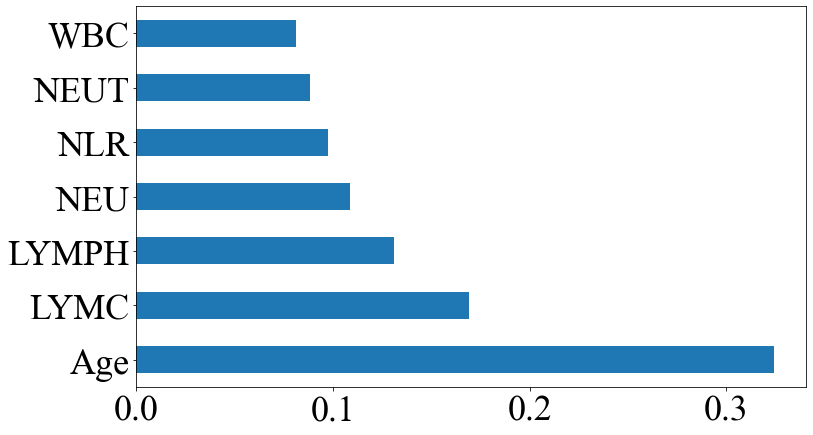

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
feat_importances = pd.Series(et.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')
import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
            "font.family": 'serif',
            "font.size": 36,
            "mathtext.fontset": 'stix',
            "font.serif": ['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号
         }
rcParams.update(config)
plt.savefig('et21.tif',dpi=600,bbox_inches='tight')

In [56]:
import shap

Xres_names=pd.DataFrame(data=x_res,columns=X.columns)

shap.initjs()

#model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(Xres_names, label=yres), 100)

explainer = shap.TreeExplainer(et)
shap_values = explainer.shap_values(Xres_names)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], Xres_names.iloc[0,:])

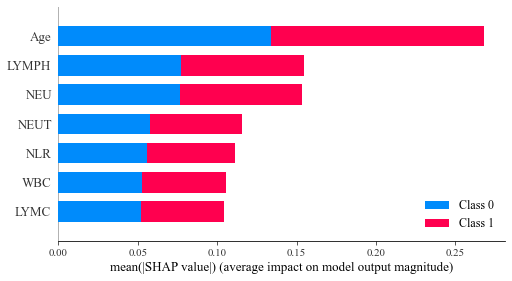

In [57]:
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# config = {
#             "font.family": 'serif',
#             "font.size": 16,
#             "mathtext.fontset": 'stix',
#             "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
#          }
# rcParams.update(config)
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.savefig('et2.tif',dpi=600,bbox_inches='tight')

In [38]:
import shap
 
explainer = shap.Explainer(et)
shap_values = explainer(X)

In [1]:
# shap.plots.bar(shap_values)

Explainer expected value: [0.5 0.5]


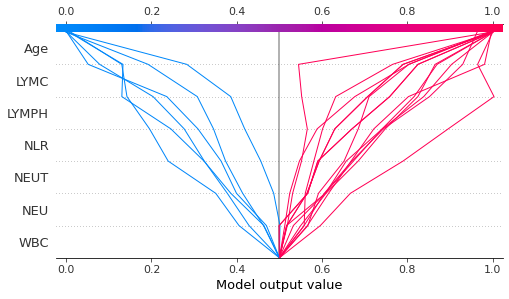

In [40]:
import warnings
explainer = shap.TreeExplainer(et)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value[0], shap_values, features_display)

In [72]:
rf = RandomForestClassifier(n_estimators=100, max_depth=19)
#     LogisticRegression(solver = 'saga', max_iter= 500, multi_class='ovr',
#                         class_weight='balanced')
rf.fit(x_res, y_res)

RandomForestClassifier(max_depth=19, n_estimators=90)

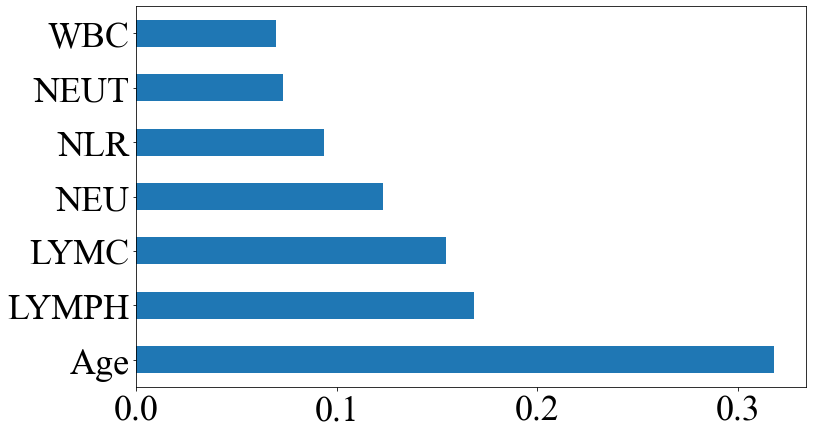

In [73]:
plt.figure(figsize=(12,7))
feat_importances = pd.Series(rf.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig('rf22.tif',dpi=600,bbox_inches='tight')

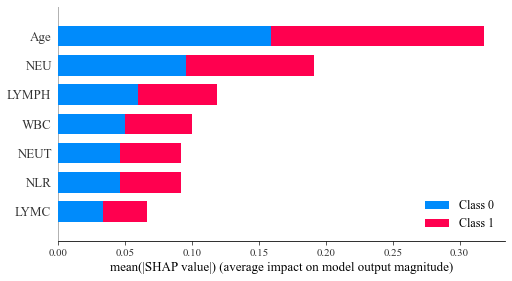

In [59]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(Xres_names)



# import matplotlib.pyplot as plt
# from matplotlib import rcParams
# config = {
#             "font.family": 'serif',
#             "font.size": 16,
#             "mathtext.fontset": 'stix',
#             "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
#          }
# rcParams.update(config)
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.savefig('rf2.tif',dpi=600,bbox_inches='tight')

Explainer expected value: [0.50121083 0.49878917]


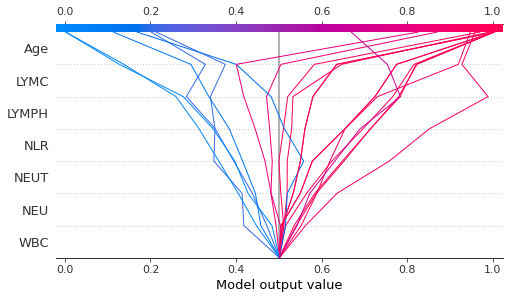

In [60]:
import warnings
explainer = shap.TreeExplainer(rf)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value[0], shap_values, features_display)

In [74]:
xgbc = XGBClassifier(n_estimators=80,learning_rate=0.45,max_depth=7,eval_metric='error')
xgbc.fit(x_res, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.75, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

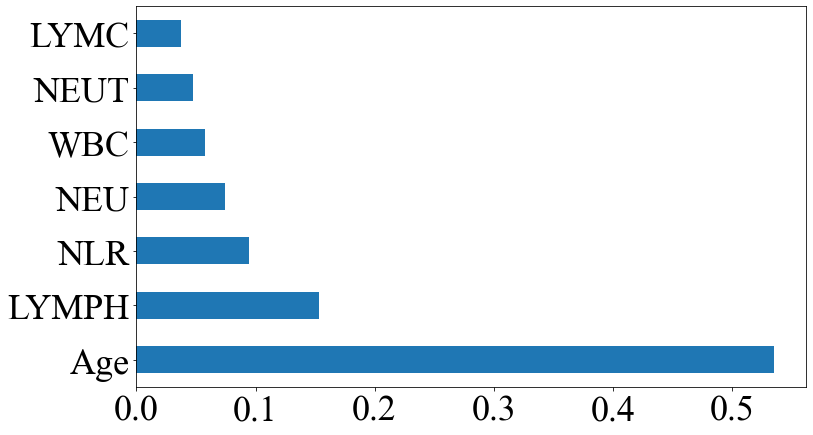

In [75]:
plt.figure(figsize=(12,7))
feat_importances = pd.Series(xgbc.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig('xgb23.tif',dpi=600,bbox_inches='tight')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


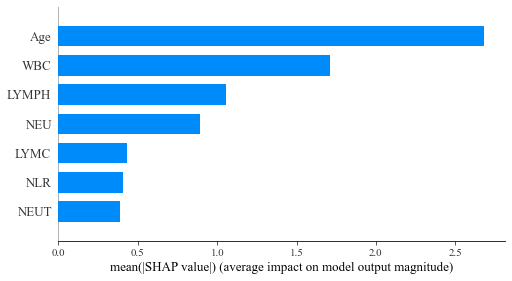

In [61]:
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(Xres_names)
# import matplotlib.pyplot as plt
# from matplotlib import rcParams
# config = {
#             "font.family": 'serif',
#             "font.size": 16,
#             "mathtext.fontset": 'stix',
#             "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
#          }
# rcParams.update(config)
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.savefig('xgb2.tif',dpi=600,bbox_inches='tight')

Explainer expected value: [0.00680949]


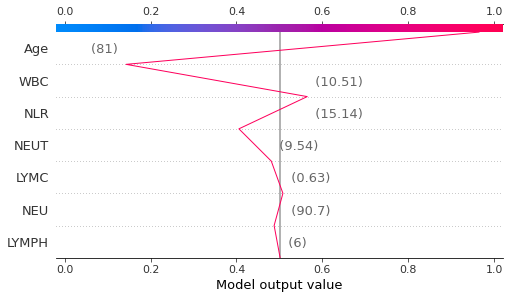

In [64]:
import warnings
explainer = shap.TreeExplainer(xgbc)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value, shap_values, features_display, link ='logit')

Explainer expected value: [0.00680949]


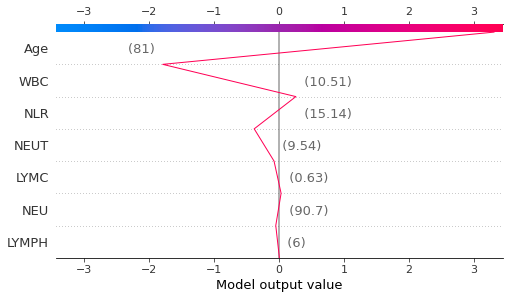

In [65]:
import warnings
explainer = shap.TreeExplainer(xgbc)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value[0], shap_values, features_display)

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(x_res, y_res)

GradientBoostingClassifier()

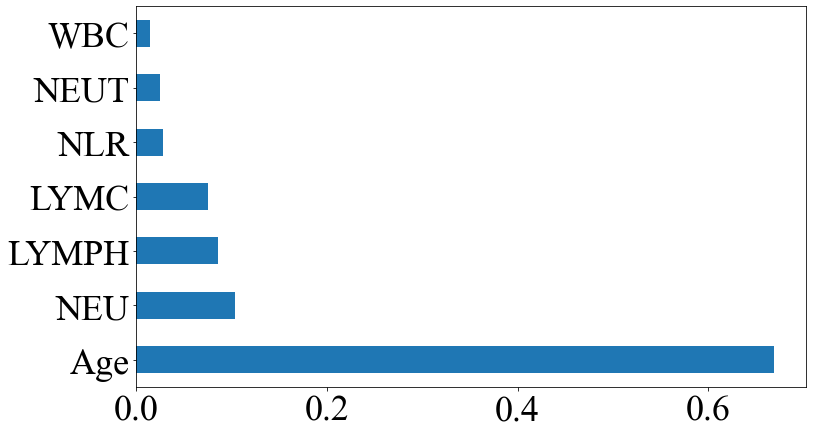

In [77]:
plt.figure(figsize=(12,7))
feat_importances = pd.Series(gb.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig('gbdt24.tif',dpi=600,bbox_inches='tight')

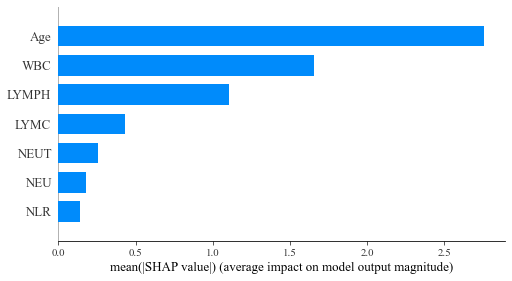

In [63]:
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(Xres_names)
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# config = {
#             "font.family": 'serif',
#             "font.size": 16,
#             "mathtext.fontset": 'stix',
#             "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
#          }
# rcParams.update(config)
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.savefig('gbdt2.tif',dpi=600,bbox_inches='tight')

Explainer expected value: [0.29099705]


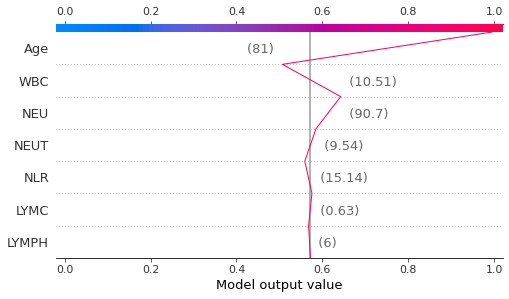

In [51]:
import warnings
explainer = shap.TreeExplainer(gb)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value, shap_values, features_display, link ='logit')